In [62]:
from datetime import datetime
from itertools import product
import warnings

from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sts

%matplotlib inline
plt.rcParams['figure.figsize'] = (16., 8.)

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', parse_dates=['month'], index_col='month', dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Построим наш ряд

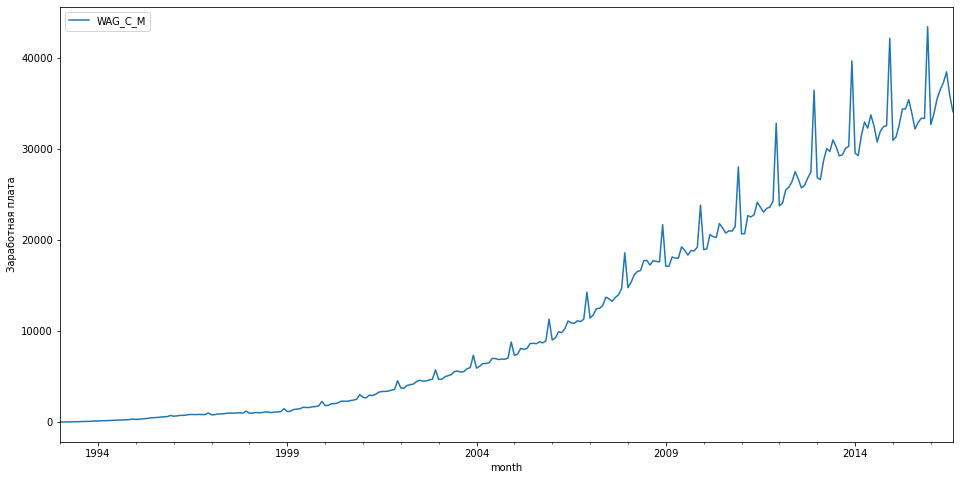

In [3]:
data.plot()
plt.ylabel('Заработная плата');

Критерий Дики-Фуллера: 0.9918495954854734


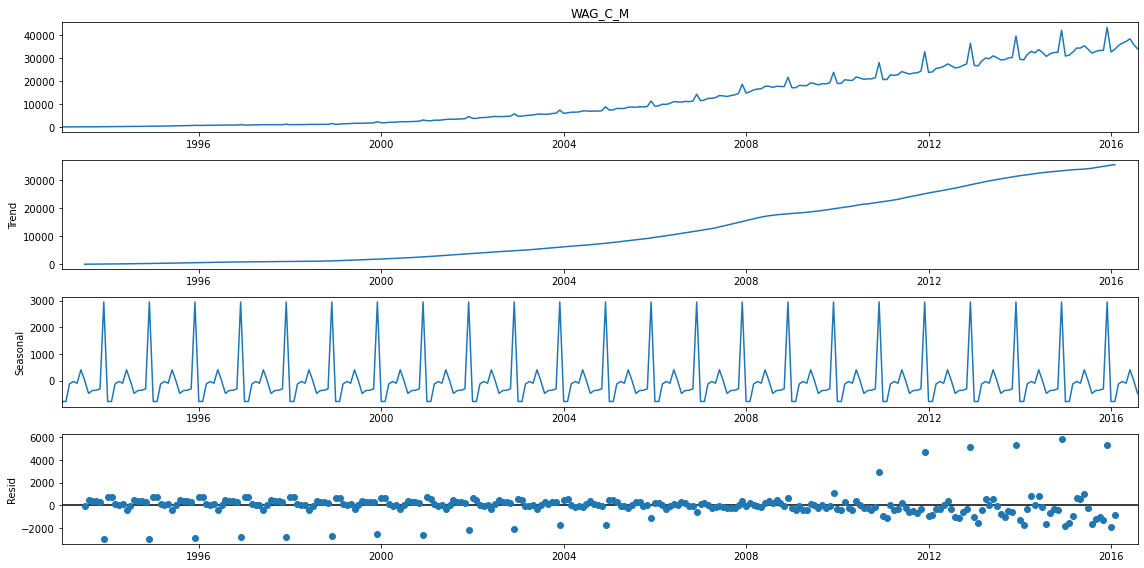

In [4]:
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print(f'Критерий Дики-Фуллера: {sm.tsa.adfuller(data.WAG_C_M)[1]}')

### Критерий Дики-Фуллера говорит о нестационарности ряда достаточно уверенно, применим преобразование Бокса-Кокса и посмотрим еще раз

Оптимальный параметр для преобразования: 0.2632017541844584
Критерий Дики-Фуллера: 0.6968987634832662


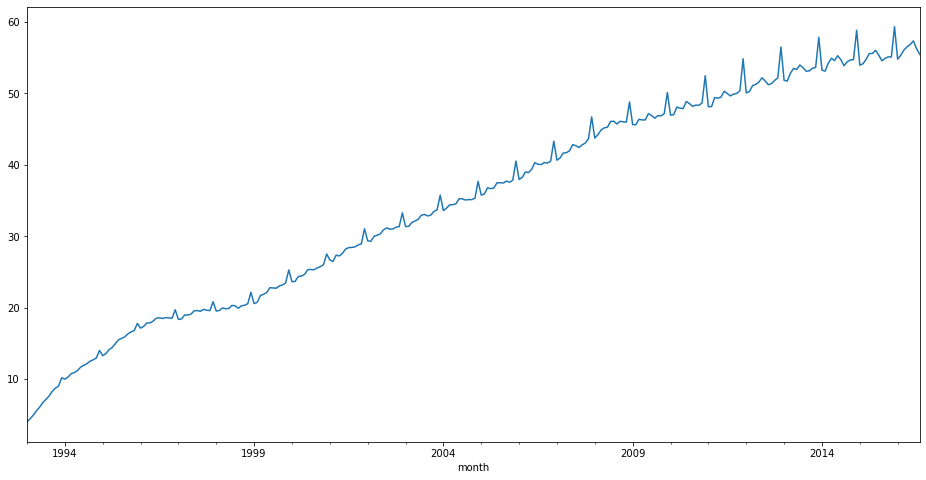

In [5]:
data['box'], lmbda = sts.boxcox(data.WAG_C_M)
data['box'].plot()
print(f'Оптимальный параметр для преобразования: {lmbda}')
print(f'Критерий Дики-Фуллера: {sm.tsa.adfuller(data.box)[1]}')

### Применим сезонное дифференцирование

Критерий Дики-Фуллера: 0.014697133494791847


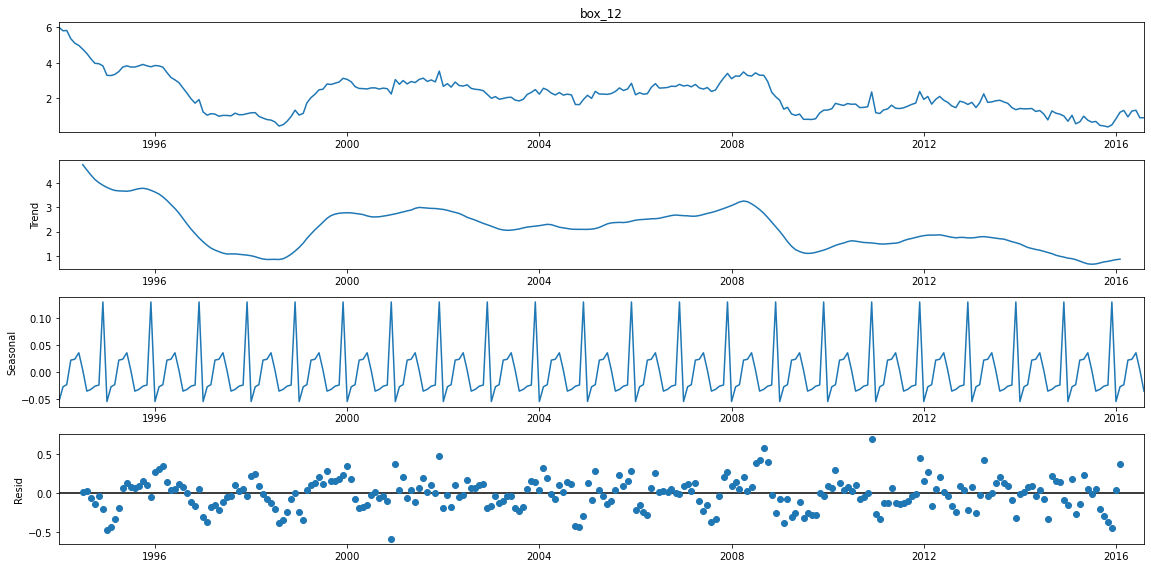

In [6]:
data['box_12'] = data['box'] - data['box'].shift(12)
sm.tsa.seasonal_decompose(data.dropna().box_12).plot()
print(f'Критерий Дики-Фуллера: {sm.tsa.adfuller(data.dropna().box_12)[1]}')

### На этот раз критерий Дики-Фуллера отвергает гипотезу о нестационарности, но зрительно можно наблюдать, что остатки имеют зависимость от времени, да и тренд все-таки присутствует
### Сделаем дифференцирование ряда

Критерий Дики-Фуллера: 5.203603715821792e-08


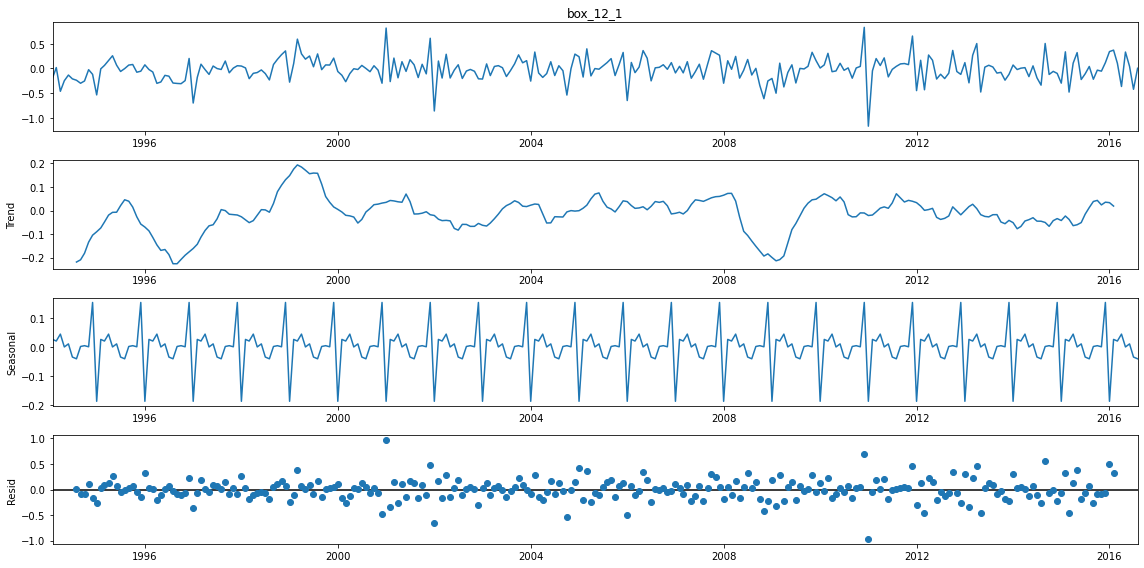

In [16]:
data['box_12_1'] = data['box_12'] - data['box_12'].shift(1)
sm.tsa.seasonal_decompose(data.dropna().box_12_1).plot()
print(f'Критерий Дики-Фуллера: {sm.tsa.adfuller(data.dropna().box_12_1)[1]}')

### Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности, тренда зрительно не наблюдается и остатки на вид не зависят от времени

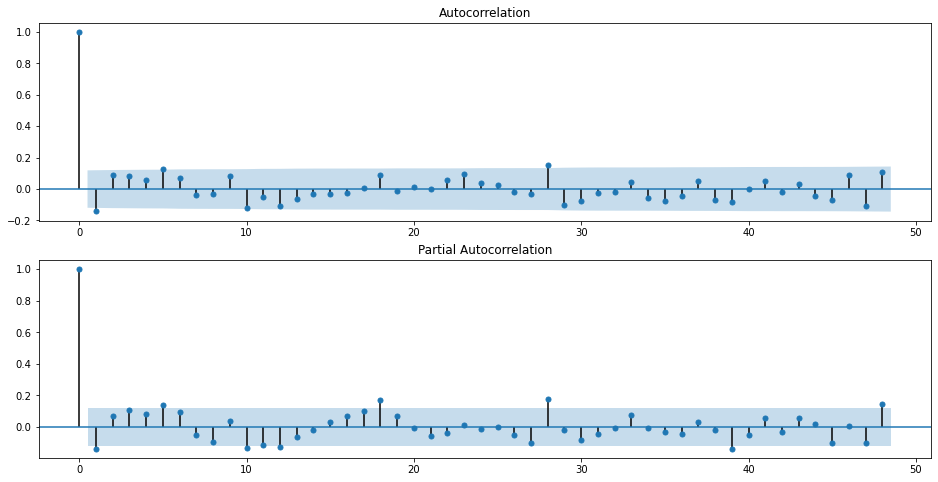

In [80]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.box_12_1.dropna().values.squeeze(), lags=48, ax=ax);
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.box_12_1.dropna().values.squeeze(), lags=48, ax=ax);

### Начальные приближения: p=1, P=1, q=1, Q=0

In [97]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [98]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [99]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3.29 s


In [100]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
5,"(1, 0, 1, 0)",110.715725
3,"(0, 1, 1, 0)",112.072487
7,"(1, 1, 1, 0)",112.238988
1,"(0, 0, 1, 0)",117.025251
0,"(0, 0, 0, 0)",208.965597


In [101]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 12)   Log Likelihood                 -52.358
Date:                            Mon, 06 Dec 2021   AIC                            110.716
Time:                                    12:17:49   BIC                            121.386
Sample:                                01-01-1993   HQIC                           115.006
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1796      0.048     -3.708      0.000      -0.274      -0.085
ar.S.L12      -0.5851      0.044   

Критерий Стьюдента: p=0.980744
Критерий Дики-Фуллера: p=0.000000


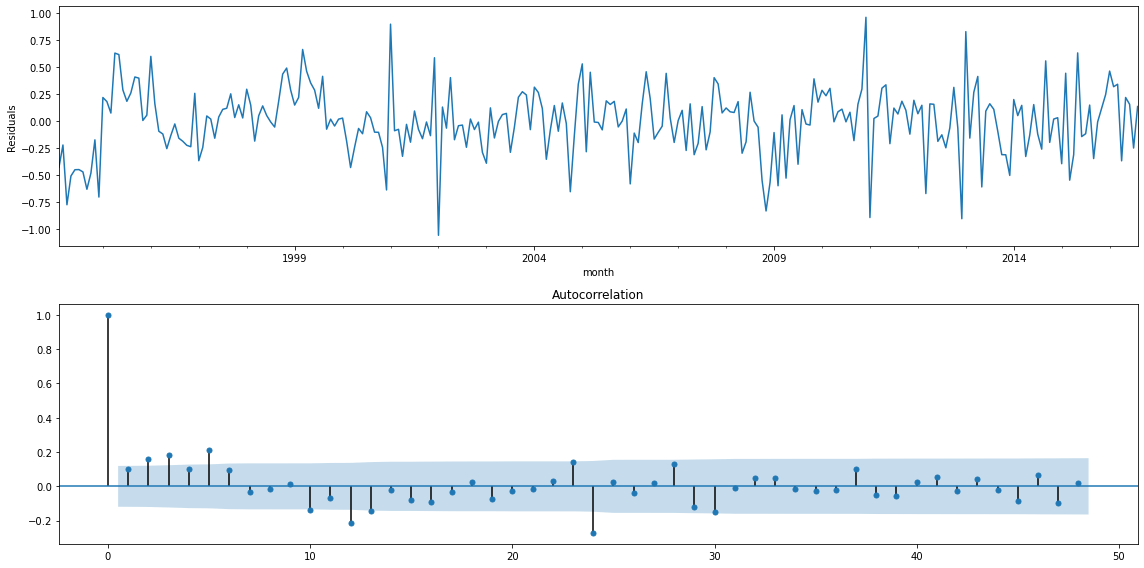

In [105]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze()[13:], lags=48, ax=ax)
plt.tight_layout()

print("Критерий Стьюдента: p=%f" % sts.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

### Остатки несмещенные, но автокореллированные, расширим область поиска p, q, P, Q и посмотрим на новые остатки

In [107]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

In [108]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3min 19s


In [109]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
72,"(2, 2, 0, 0)",-21.488595
75,"(2, 2, 1, 0)",-21.473459
73,"(2, 2, 0, 1)",-21.240101
76,"(2, 2, 1, 1)",-21.053113
80,"(2, 2, 2, 2)",-20.393599


In [110]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Mon, 06 Dec 2021   AIC                            -21.489
Time:                                     12:34:22   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.956      0.000       1.400       1.571
ar.L2         -0.6839      

Критерий Стьюдента: p=0.269829
Критерий Дики-Фуллера: p=0.000000


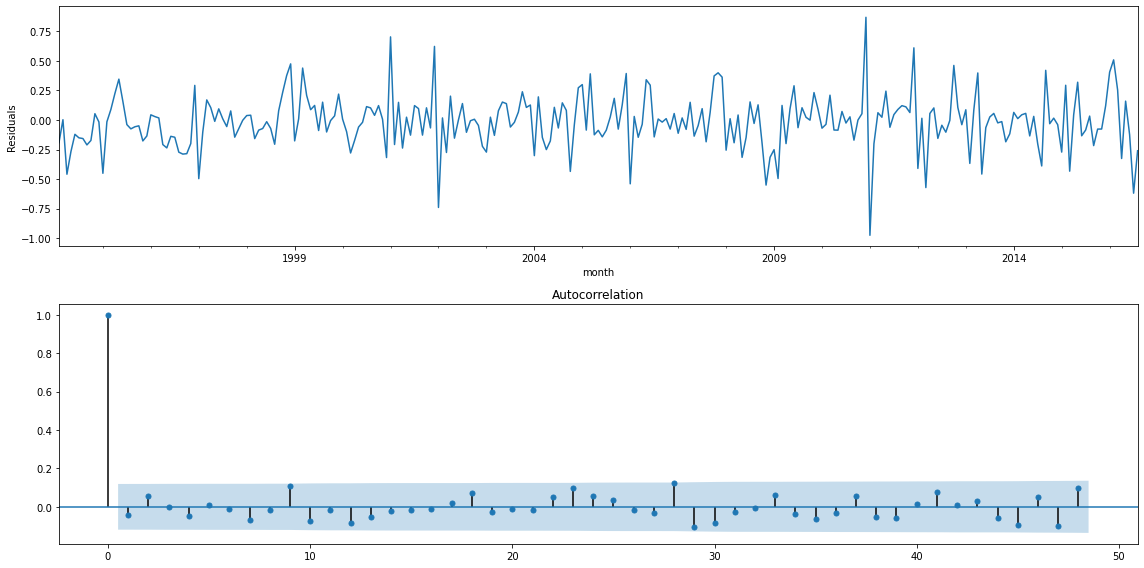

In [115]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze()[13:], lags=48, ax=ax)
plt.tight_layout()

print("Критерий Стьюдента: p=%f" % sts.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

### Результаты модели

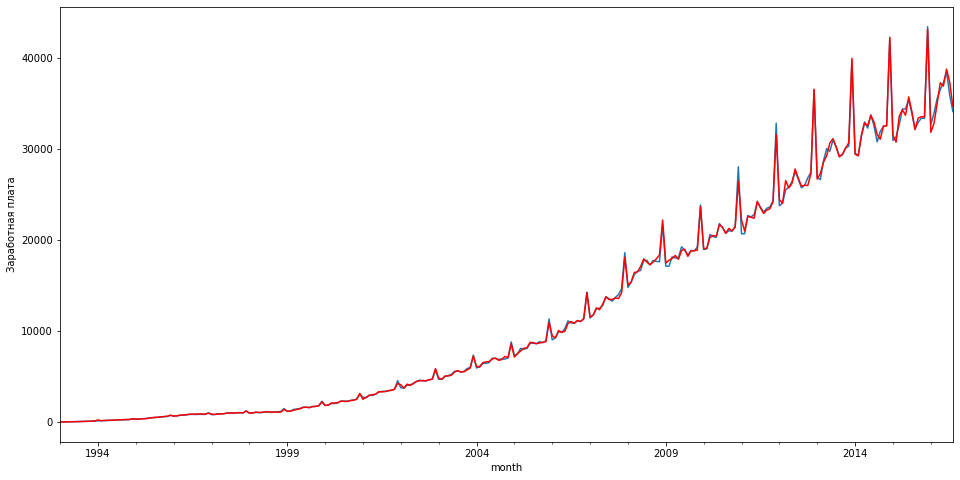

In [112]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data.WAG_C_M.plot()
data.model.plot(color='r')
plt.ylabel('Заработная плата');

### Прогноз

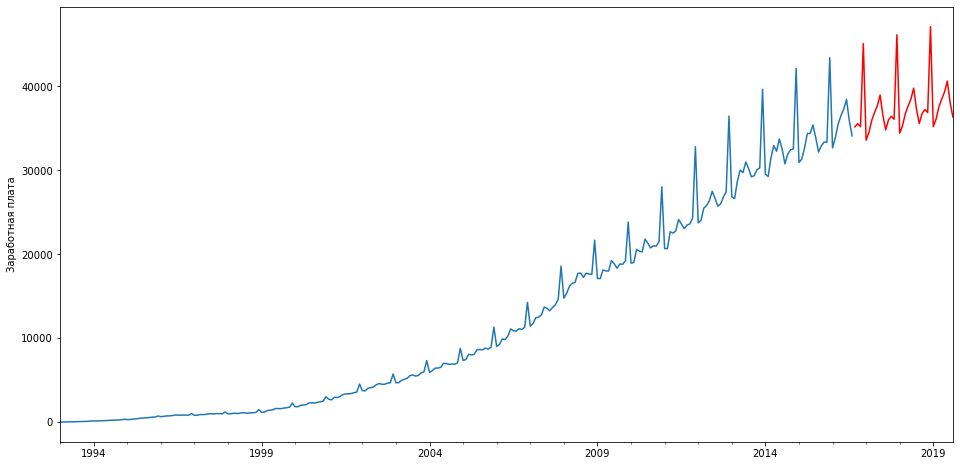

In [113]:
data2 = data[['WAG_C_M']]
date_list = [datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Заработная плата');